# Exploring the Enron dataset:

In this project I will explore the Enron email dataset and examine a number of clasifiers to predictthe POI (i.e. Point of Interest) person, based on a number of features extracted from the indivisuals' emails. This process will include identifying and removing the outliers, creating new features based on the previous ones, and engineering classifiers and tuning them to improve the overall prediction accuracy. 

In [98]:
'''First we will read and examine teh dataset'''
import sys
import pickle
import pandas as pd
import os
import seaborn as sb
import matplotlib.pyplot as plt
from feature_format import featureFormat, targetFeatureSplit

from numpy import mean
from feature_format import featureFormat, targetFeatureSplit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import tree
from sklearn.grid_search import GridSearchCV


os.chdir("C:/Users/sur216/Box Sync/school stuff/Udacity (sur216@psu.edu)/Data Analyst/p5_enron/ud120-projects-master/final_project")
data_dict = pickle.load(open("final_project_dataset.pkl", "r"))
print "the number of items in the dictionary is: {0}".format(len(data_dict.keys()))
print "the email sensers/recipients are: {0}".format(data_dict.keys())
print "and the current features for each row in the dataste are: {0}".format(data_dict.values()[1].keys())

the number of items in the dictionary is: 146
the email sensers/recipients are: ['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNAN

In [99]:
def to_pandas(data_dict):
    df = pd.DataFrame(data_dict)
    df = df.convert_objects(convert_numeric=True)
    df = df.transpose()
    df.reset_index(level=0, inplace=True)
    columns = list(df.columns)
    columns[0] = 'name'
    df.columns = columns
    return(df)
df = to_pandas(data_dict)
bypoi = df.groupby(['poi'])
print "number of features: ", len(df.keys()), "\n"
print bypoi['poi'].agg([len])

number of features:  22 

       len
poi       
0.0  128.0
1.0   18.0


C:\Users\sur216\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


We can see that only a small proportion of the individuals are POI (18 out of 128). This makes the classification process a little difficult. A classifier in order to be useful, in this case, needs to have a high recall value (i.e. the ability of classifier to find all the positive samples) without comprimising the percision as much. 

In [100]:
df.isnull().sum()

name                           0
bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                146
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64

It's important to check the missing values in our dataset as too many missing values will be problematic in terms of the usability of a given feature. AS printed above, a lot of email addresses are missing but that's as important since we will not use it as a feature for our models. "loan_advances", "director_fees", "deferral_payments" and "restricted_stock+deferred", are some numerical features that have a relevantly large number of missing values which makes them less useful features. 

146


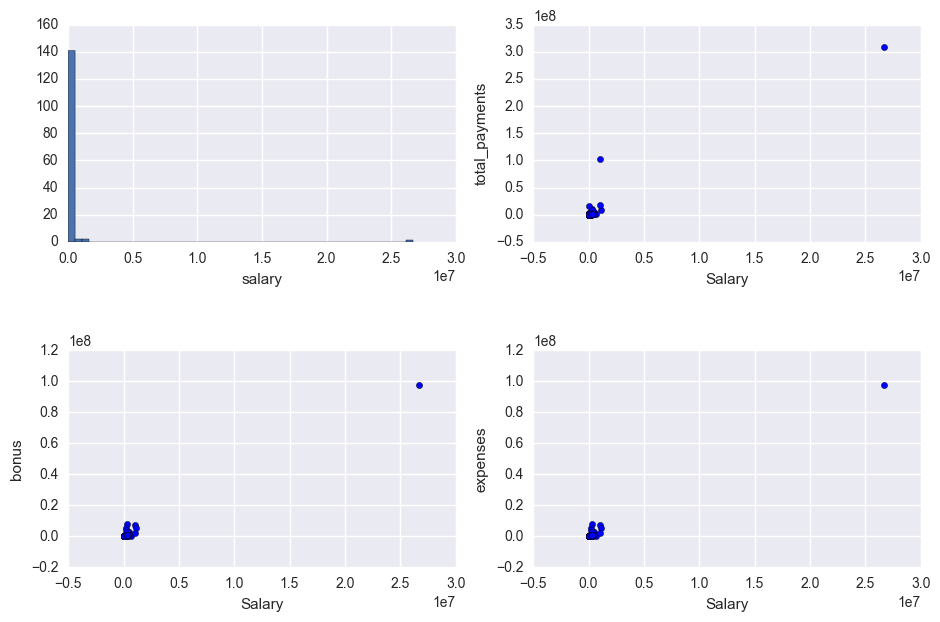

In [101]:
# extract features from the dictionary
feature_1 = "salary"
feature_2 = "exercised_stock_options"
feature_3 = "total_payments"
feature_4 = "bonus"
feature_5 = "expenses"
poi  = "poi"
features_list = [poi, feature_1, feature_2, feature_3,feature_4,feature_5]

# make lists from the dataset for our scatter plots
def finance_to_list (input_data): 
    data = featureFormat(input_data, features_list, remove_all_zeroes=False, remove_any_zeroes=False)
    poi, finance_feat = targetFeatureSplit( data )
    salary = []
    ex_stock = []
    tot_pay = []
    bonus = []
    expens = []
    for point in finance_feat: 
        salary.append(point[0])
        ex_stock.append(point[1])
        tot_pay.append(point[2])
        bonus.append(point[3])
        expens.append(point[4])
    return ([salary,ex_stock,tot_pay,bonus,expens,poi])   

 
print(len(finance_to_list(data_dict)[2]))

# plot multiple subplots
%matplotlib inline
plt.rcParams['figure.figsize'] = (11, 7)
f, axarr = plt.subplots(2, 2)
axarr[0, 0].hist(finance_to_list(data_dict)[0], bins = 50)
axarr[0, 0].set_xlabel('salary')
axarr[0, 1].scatter(finance_to_list(data_dict)[0], finance_to_list(data_dict)[2])
axarr[0, 1].set_xlabel('Salary')
axarr[0, 1].set_ylabel('total_payments')
axarr[1, 0].scatter(finance_to_list(data_dict)[0], finance_to_list(data_dict)[3])
axarr[1, 0].set_xlabel('Salary')
axarr[1, 0].set_ylabel('bonus')
axarr[1, 1].scatter(finance_to_list(data_dict)[0], finance_to_list(data_dict)[3])
axarr[1, 1].set_xlabel('Salary')
axarr[1, 1].set_ylabel('expenses')
f.subplots_adjust(hspace=0.5)

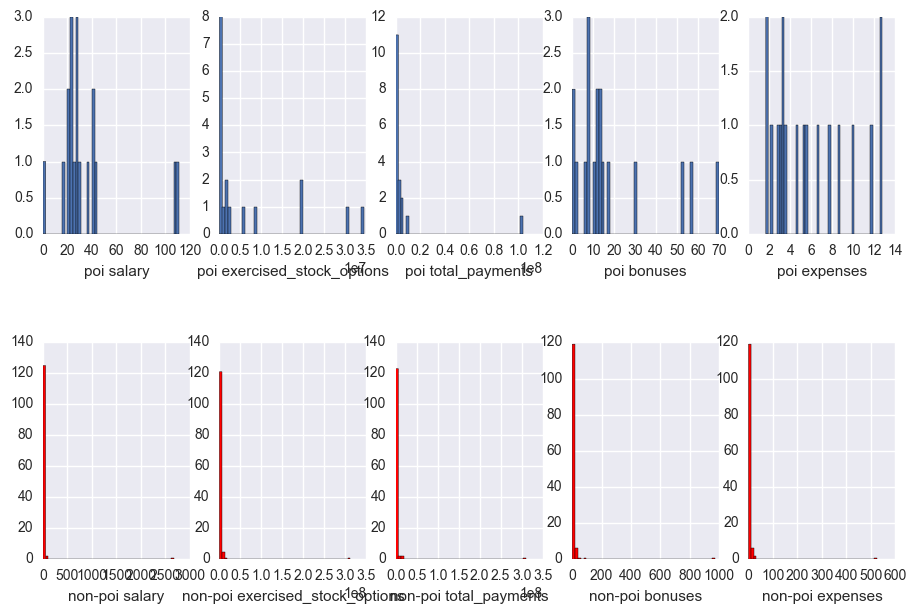

In [102]:
'''we will first compare the two '''

# list of POI values in the enron data
pois = finance_to_list(data_dict)[5]
poi_indices = []
non_poi_indices = []
c = -1
for i in pois:
    c +=1
    if int(i)==1: poi_indices.append(c)
    else: non_poi_indices.append(c)


def get_poi(poi_indices):     
    poi_sal = []
    poi_exe = []
    poi_tot = []
    poi_bon = []
    poi_exp = []
    for i in poi_indices:
        poi_sal.append(finance_to_list(data_dict)[0][i]/10000)
        poi_exe.append(finance_to_list(data_dict)[1][i])
        poi_tot.append(finance_to_list(data_dict)[2][i])
        poi_bon.append(finance_to_list(data_dict)[3][i]/100000)
        poi_exp.append(finance_to_list(data_dict)[4][i]/10000)
    return [poi_sal,poi_exe,poi_tot,poi_bon,poi_exp]


plt.rcParams['figure.figsize'] = (11, 7)
f, axarr = plt.subplots(2, 5)
axarr[0, 0].hist(get_poi(poi_indices)[0], bins = 50)
axarr[0, 0].set_xlabel('poi salary')
axarr[0, 1].hist(get_poi(poi_indices)[1], bins = 50)
axarr[0, 2].hist(get_poi(poi_indices)[2], bins = 50)
axarr[0, 2].set_xlabel('poi total_payments')
axarr[0, 3].hist(get_poi(poi_indices)[3], bins = 50)
axarr[0, 3].set_xlabel('poi bonuses')
axarr[0, 4].hist(get_poi(poi_indices)[4], bins = 50)
axarr[0, 4].set_xlabel('poi expenses')
axarr[1, 0].hist(get_poi(non_poi_indices)[0], bins = 50, color = "red")
axarr[1, 0].set_xlabel('non-poi salary')
axarr[1, 1].hist(get_poi(non_poi_indices)[1], bins = 50, color = "red")
axarr[1, 1].set_xlabel('non-poi exercised_stock_options')
axarr[1, 2].hist(get_poi(non_poi_indices)[2], bins = 50, color = "red")
axarr[1, 2].set_xlabel('non-poi total_payments')
axarr[1, 3].hist(get_poi(non_poi_indices)[3], bins = 50, color = "red")
axarr[1, 3].set_xlabel('non-poi bonuses')
axarr[1, 4].hist(get_poi(non_poi_indices)[4], bins = 50, color = "red")
axarr[1, 4].set_xlabel('non-poi expenses')
axarr[0, 1].set_xlabel('poi exercised_stock_options')
f.subplots_adjust(hspace=0.5)    

In [103]:
# there is an extreme outlier
for k, v in data_dict.items():
     if v['salary'] != 'NaN' and v['salary'] > 1000000: print k

LAY KENNETH L
SKILLING JEFFREY K
TOTAL
FREVERT MARK A


We can see that there is "Total" in the receipents list which does not make sense. We will now define a function to give us the 5 largers features so that we can look closer and see if there are any particular outliers. 

In [104]:
# we ill define a function to find the five largest values for each financial feature
def show_largest_five(data_dict, features, feature):
    print "5 largest", feature
    sorted_list = sorted(data_dict.iteritems(), 
                 key=lambda (key, val): int(0 if val[feature] == 'NaN' else val[feature]), reverse=True)[0:5]
    print [(i[0]+ "(" + ('poi' if i[1]['poi'] else 'not poi') + "): "+ str(i[1][feature])) for i in sorted_list]
show_largest_five(data_dict, finance_to_list (data_dict), 'bonus')
show_largest_five(data_dict, finance_to_list (data_dict), 'exercised_stock_options')
show_largest_five(data_dict, finance_to_list (data_dict), 'loan_advances')
show_largest_five(data_dict, finance_to_list (data_dict), 'other')
show_largest_five(data_dict, finance_to_list (data_dict), 'restricted_stock')
show_largest_five(data_dict, finance_to_list (data_dict), 'restricted_stock_deferred')

5 largest bonus
['TOTAL(not poi): 97343619', 'LAVORATO JOHN J(not poi): 8000000', 'LAY KENNETH L(poi): 7000000', 'SKILLING JEFFREY K(poi): 5600000', 'BELDEN TIMOTHY N(poi): 5249999']
5 largest exercised_stock_options
['TOTAL(not poi): 311764000', 'LAY KENNETH L(poi): 34348384', 'HIRKO JOSEPH(poi): 30766064', 'RICE KENNETH D(poi): 19794175', 'SKILLING JEFFREY K(poi): 19250000']
5 largest loan_advances
['TOTAL(not poi): 83925000', 'LAY KENNETH L(poi): 81525000', 'FREVERT MARK A(not poi): 2000000', 'PICKERING MARK R(not poi): 400000', 'METTS MARK(not poi): NaN']
5 largest other
['TOTAL(not poi): 42667589', 'LAY KENNETH L(poi): 10359729', 'FREVERT MARK A(not poi): 7427621', 'MARTIN AMANDA K(not poi): 2818454', 'BAXTER JOHN C(not poi): 2660303']
5 largest restricted_stock
['TOTAL(not poi): 130322299', 'LAY KENNETH L(poi): 14761694', 'WHITE JR THOMAS E(not poi): 13847074', 'PAI LOU L(not poi): 8453763', 'SKILLING JEFFREY K(poi): 6843672']
5 largest restricted_stock_deferred
['BHATNAGAR SANJA

Other than "Total" th eother values eems to be fine. Just to make sure, we will print the receipents' names once again to double check. 

In [94]:
print "the email sensers/recipients are: {0}".format(data_dict.keys())

the email sensers/recipients are: ['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHA

Other than Total, there seems to be another outlier: 'THE TRAVEL AGENCY IN THE PARK' which does not make sense because it's not a person's name. So we found two outliers overall and we will delete them here. 

In [105]:
#turns out to be the TOTAL row from the salaries & bonuses list, let's remove it
del data_dict["TOTAL"]
del data_dict['THE TRAVEL AGENCY IN THE PARK']

# Task 3: Creat New Feature(s)

It would make sense to take a closer look at the communication patterns of these names via email. So, I will first take a look at the relevant features.

 The number of these emails alone will not inform us anything specific. A better idea would be to make a few features from these to see the extent of a person's communication with the poi as a proportion of the total number of his/her emails. Therefor, I will make two additional features: first, from_poi_to_this_person/to_messages and seconf, from_this_person_to_poi/from_messages. we will then add these two features to the list of features. 
 
 I will also make a new feature for a peron's total financail activitiy (i.e total_money) by adding up these features: 'salary','total_stock_value','exercised_stock_options','bonus'

In [12]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

## emails: 
for item in my_dataset:
    ind = my_dataset[item]
    if (all([ind['from_poi_to_this_person'] != 'NaN',ind['from_this_person_to_poi'] != 'NaN',
        ind['to_messages'] != 'NaN',ind['from_messages'] != 'NaN'])):
        fraction_from_poi = float(ind["from_poi_to_this_person"]) / float(ind["to_messages"])
        ind["ratio_from_poi"] = fraction_from_poi
        fraction_to_poi = float(ind["from_this_person_to_poi"]) / float(ind["from_messages"])
        ind["ratio_to_poi"] = fraction_to_poi
    else:
        ind["ratio_from_poi"] = ind["ratio_to_poi"] = 0


## Financial:
for item in my_dataset:
    ind = my_dataset[item]
    if (all([ind['salary'] != 'NaN', ind['total_stock_value'] != 'NaN', 
             ind['exercised_stock_options'] != 'NaN',ind['bonus'] != 'NaN'])):
        ind['total_money'] = sum([ind[field] for field in ['salary','total_stock_value','exercised_stock_options','bonus']])
    else:
        ind['total_money'] = 'NaN'

Although the new features intuitively make sense, I will ckeck to see if it actually improves either percision or recall. To this end, I will create two feature lists: first, all features plus those that I just created   which I name "my_features" and second those featurese that were given in the dataset. I will name the later "given_fetures":

In [74]:
my_features = features_list + ['ratio_from_poi','ratio_to_poi','shared_receipt_with_poi','expenses','loan_advances',
                               'long_term_incentive','other','restricted_stock','restricted_stock_deferred','deferral_payments',
                                'deferred_income','salary','total_stock_value','exercised_stock_options','total_payments',
                               'bonus','total_money']

given_features = features_list + ['shared_receipt_with_poi','expenses','loan_advances',
                               'long_term_incentive','other','restricted_stock','restricted_stock_deferred','deferral_payments',
                                'deferred_income','salary','total_stock_value','exercised_stock_options','total_payments',
                               'bonus']

data = featureFormat(my_dataset, my_features, sort_keys = True)
data2 = featureFormat(my_dataset, given_features, sort_keys = True)

labels, features = targetFeatureSplit(data)
labels2, features2 = targetFeatureSplit(data2)

print "my features:", my_features
print "goven features:", given_features


my features: ['poi', 'salary', 'exercised_stock_options', 'total_payments', 'bonus', 'expenses', 'ratio_from_poi', 'ratio_to_poi', 'shared_receipt_with_poi', 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'deferral_payments', 'deferred_income', 'salary', 'total_stock_value', 'exercised_stock_options', 'total_payments', 'bonus', 'total_money']
goven features: ['poi', 'salary', 'exercised_stock_options', 'total_payments', 'bonus', 'expenses', 'shared_receipt_with_poi', 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'deferral_payments', 'deferred_income', 'salary', 'total_stock_value', 'exercised_stock_options', 'total_payments', 'bonus']


Now I will choose a classifies, say Random Forest. I will use grid search function and assign a number of parameters and choose the best classifier. I will do this process twice: once with my_features as in put featur elist and the second time only with the given features that we had in the dataset in the first place. I will then calculate the recall and percision. Before this step, however, I will define a function to conduct a k-fold cross validation and calculate the recall and percision for us. Her eis the function: 

In [31]:
# define tester function
def test_clf(grid_search, features, labels, parameters, iterations=100):
    from sklearn.metrics import classification_report
    precision, recall = [], []
    for iteration in range(iterations):
        features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=iteration)
        grid_search.fit(features_train, labels_train)
        predictions = grid_search.predict(features_test)
    print classification_report(labels_test, predictions)
    best_params = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print '%s=%r, ' % (param_name, best_params[param_name])

Now let's test the classifiers on two feature lists and see which one performs better: 

In [87]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

t0= time()
parameters = {'n_estimators':[2,5], 'min_samples_split': [2,3], 
              'min_impurity_split' : [1e-7,1e-15]}
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, parameters)

print "results for my features"
test_clf(grid_search, features, labels, parameters)
print "results for the given features"
test_clf(grid_search, features2, labels2, parameters)

results for my features
             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94        32
        1.0       0.50      0.25      0.33         4

avg / total       0.87      0.89      0.87        36

min_impurity_split=1e-15, 
min_samples_split=3, 
n_estimators=5, 
results for the given features
             precision    recall  f1-score   support

        0.0       0.88      0.91      0.89        32
        1.0       0.00      0.00      0.00         4

avg / total       0.78      0.81      0.79        36

min_impurity_split=1e-15, 
min_samples_split=2, 
n_estimators=2, 


As you can see the my_feature list performs better and it looks like our newly added features have already improved the results. Now we can go ahead and tune our classifiers and choose the best number of features. 

# Examine and tune different classifiers

In this section we will try a number of classifiers and choose the best classifiers as out final model. Our criteria for selecting the best classifier are two measures namely, "recall" and "percision". Recall is the ability of classifier to identify all the positive values while percision is its ability to not falsely assign positive values to those values that are actually negative. Using these two we can understand how accurate our model is in identofying the POI individuals within the entire dataset. 

Cross validation is a common practice in machine learning to makes sure that the model that we have selected is capable of actually predicting the desired values. The purpose of cross validation is to test the model multiple times and make balance between model bias and variance. Overfitting, occures when we have a high variance in our model and is one of the most challenging things to avoid from in machin learning. Cross validation enable use to first fit a model on a portion of our data set (train) and then try the model on the remainder of the dataset (test) and calculate th error. Different techniques for cross validation exists (i.e. Leave One Out, K fold etc.) the most commonly used how ever is the k-fold with k = 10. Leave one out leads to more balanced models however it comes with a high computational cost. 

The function above conducts a k-fold cross validation (k = 100) to test a classifier.This function enable us to see calculate the avergae recall and percision for the entire dataset by dividing the datset into 100 folds, fir a model in 99 of them and test it on th eone left and iterate that process for all 100 folds. No wwe will go ahead an try a numer of classifiers. For each classifier, I will calculate the recall and percision for a number of different parameters. Also I will try different numbers of features. For the k-best feature selection method, I will try a model with {2,3,4,5} best features. I will try the PCA method as well with {2,3,4,5} principal components. We can then see which parameters and features are best for each classifier.

In [88]:
data = featureFormat(my_dataset, my_features, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
#define a function to return the first k principal components   
def doPCA(data,k): 
    from sklearn.decomposition import PCA
    pca = PCA(n_components = k)
    pca.fit(data)
    return pca  

In [37]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier
from time import time
clf = AdaBoostClassifier()
t0= time()
parameters = {'n_estimators': [10, 20, 40],
               'algorithm': ['SAMME', 'SAMME.R'],
               'learning_rate': [.5, 1, 1.5]}
grid_search = GridSearchCV(clf, parameters)
for i in [2,3,4,5]:
    k_best = SelectKBest(k=i)
    k_features = k_best.fit_transform(features, labels)
    print "K best features with k = {0}".format(i)
    test_clf(grid_search, k_features, labels, parameters)

print '\nAdaBoost (pca features):'
for i in [2,3,4,5]:
    pca = doPCA(features_train,i)
    pca.fit(features_train)
    pca_features = pca.transform(features)
    print "{0} principal components:".format(i)
    test_clf(grid_search, pca_features, labels, parameters)
print '\nAdaBoost (Best k features):'

print '\nAdaBoost total time:{0}s'.format(round(time()-t0, 3))

K best features with k = 2
             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94        32
        1.0       0.50      0.25      0.33         4

avg / total       0.87      0.89      0.87        36

algorithm='SAMME', 
learning_rate=0.5, 
n_estimators=10, 
K best features with k = 3
             precision    recall  f1-score   support

        0.0       0.91      0.94      0.92        32
        1.0       0.33      0.25      0.29         4

avg / total       0.85      0.86      0.85        36

algorithm='SAMME', 
learning_rate=0.5, 
n_estimators=10, 
K best features with k = 4
             precision    recall  f1-score   support

        0.0       0.89      0.97      0.93        32
        1.0       0.00      0.00      0.00         4

avg / total       0.79      0.86      0.82        36

algorithm='SAMME', 
learning_rate=0.5, 
n_estimators=10, 
K best features with k = 5
             precision    recall  f1-score   support

        0.0       0

In [38]:
# decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
t0= time()
parameters = {'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 10, 20],
               'max_depth': [None, 2, 5, 10],
               'min_samples_leaf': [1, 5, 10],
               'max_leaf_nodes': [None, 5, 10, 20]}
grid_search = GridSearchCV(clf, parameters)
for i in [2,3,4,5]:
    k_best = SelectKBest(k=i)
    k_features = k_best.fit_transform(features, labels)
    print "K best features with k = {0}".format(i)
    test_clf(grid_search, k_features, labels, parameters)

print '\nDecision Tree (pca features):'
for i in [2,3,4,5]:
    pca = doPCA(features_train,i)
    pca.fit(features_train)
    pca_features = pca.transform(features)
    print "{0} principal components:".format(i)
    test_clf(grid_search, pca_features, labels, parameters)
print '\nDecision Tree  (Best k features):'

print '\nDecision Tree total time:{0}s'.format(round(time()-t0, 3))

K best features with k = 2
             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94        32
        1.0       0.50      0.25      0.33         4

avg / total       0.87      0.89      0.87        36

criterion='gini', 
max_depth=2, 
max_leaf_nodes=None, 
min_samples_leaf=1, 
min_samples_split=2, 
K best features with k = 3
             precision    recall  f1-score   support

        0.0       0.91      0.94      0.92        32
        1.0       0.33      0.25      0.29         4

avg / total       0.85      0.86      0.85        36

criterion='gini', 
max_depth=2, 
max_leaf_nodes=None, 
min_samples_leaf=1, 
min_samples_split=10, 
K best features with k = 4


C:\Users\sur216\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94        32
        1.0       0.00      0.00      0.00         4

avg / total       0.79      0.89      0.84        36

criterion='gini', 
max_depth=None, 
max_leaf_nodes=None, 
min_samples_leaf=10, 
min_samples_split=2, 
K best features with k = 5
             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94        32
        1.0       0.00      0.00      0.00         4

avg / total       0.79      0.89      0.84        36

criterion='gini', 
max_depth=None, 
max_leaf_nodes=None, 
min_samples_leaf=10, 
min_samples_split=2, 

Decision Tree (pca features):
2 principal components:
             precision    recall  f1-score   support

        0.0       0.87      0.84      0.86        32
        1.0       0.00      0.00      0.00         4

avg / total       0.77      0.75      0.76        36

criterion='gini', 
max_depth=5, 
max_leaf_nodes=10, 
min_samples_leaf

In [39]:
#Random Forest
from time import time
from sklearn.ensemble import RandomForestClassifier

t0= time()
parameters = {'n_estimators':[2,5,10], 'min_samples_split': [2,3,5], 
              'min_impurity_split' : [1e-7,1e-15,1e-20],'warm_start' : ['TRUE','FALSE']}
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, parameters)
for i in [2,3,4,5]:
    k_best = SelectKBest(k=i)
    k_features = k_best.fit_transform(features, labels)
    print "K best features with k = {0}".format(i)
    test_clf(grid_search, k_features, labels, parameters)

print '\nRandom Forest (pca features):'
for i in [2,3,4,5]:
    pca = doPCA(features_train,i)
    pca.fit(features_train)
    pca_features = pca.transform(features)
    print "{0} principal components:".format(i)
    test_clf(grid_search, pca_features, labels, parameters)
print '\nRandom Forest  (Best k features):'

print '\nRandom Forest total time:{0}s'.format(round(time()-t0, 3))

K best features with k = 2
             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94        32
        1.0       0.50      0.25      0.33         4

avg / total       0.87      0.89      0.87        36

min_impurity_split=1e-15, 
min_samples_split=3, 
n_estimators=2, 
warm_start='TRUE', 
K best features with k = 3
             precision    recall  f1-score   support

        0.0       0.94      0.97      0.95        32
        1.0       0.67      0.50      0.57         4

avg / total       0.91      0.92      0.91        36

min_impurity_split=1e-15, 
min_samples_split=5, 
n_estimators=2, 
warm_start='TRUE', 
K best features with k = 4
             precision    recall  f1-score   support

        0.0       0.94      0.94      0.94        32
        1.0       0.50      0.50      0.50         4

avg / total       0.89      0.89      0.89        36

min_impurity_split=1e-07, 
min_samples_split=5, 
n_estimators=10, 
warm_start='FALSE', 
K best feature

In [40]:
# Naive Bayse
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
t0= time()
parameters = {}
grid_search = GridSearchCV(clf, parameters)
for i in [2,3,4,5]:
    k_best = SelectKBest(k=i)
    k_features = k_best.fit_transform(features, labels)
    print "K best features with k = {0}".format(i)
    test_clf(grid_search, k_features, labels, parameters)

print '\nGaussianNB (pca features):'
for i in [2,3,4,5]:
    pca = doPCA(features_train,i)
    pca.fit(features_train)
    pca_features = pca.transform(features)
    print "{0} principal components:".format(i)
    test_clf(grid_search, pca_features, labels, parameters)
print '\nGaussianNB  (Best k features):'

print '\nGaussianNB total time:{0}s'.format(round(time()-t0, 3))

K best features with k = 2
             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94        32
        1.0       0.50      0.25      0.33         4

avg / total       0.87      0.89      0.87        36

K best features with k = 3
             precision    recall  f1-score   support

        0.0       0.91      0.94      0.92        32
        1.0       0.33      0.25      0.29         4

avg / total       0.85      0.86      0.85        36

K best features with k = 4
             precision    recall  f1-score   support

        0.0       0.91      0.94      0.92        32
        1.0       0.33      0.25      0.29         4

avg / total       0.85      0.86      0.85        36

K best features with k = 5
             precision    recall  f1-score   support

        0.0       0.91      0.94      0.92        32
        1.0       0.33      0.25      0.29         4

avg / total       0.85      0.86      0.85        36


GaussianNB (pca features):
2 pr

# Final Pickle files

Of all the classifiers that we tested, the RandomForest classifier with K=3 features selected via the k-best method results in the highest recall and percision values: percision = 0.67 and recall = 0.50.  we will therefore choose this classifier. 

In [69]:
# K-best features
k_best = SelectKBest(k=5)
k_best.fit(features, labels)

results_list = zip(k_best.get_support(), my_features[1:], k_best.scores_)
results_list = sorted(results_list, key=lambda x: x[2], reverse=True)#print "K-best features:", results_list
print results_list
## 3 best features chosen by SelectKBest
my_features = features_list + ['exercised_stock_options','total_stock_value',
                                'bonus','salary','total_payments']

data = featureFormat(my_dataset, my_features, sort_keys = True)
labels, features = targetFeatureSplit(data)

[(True, 'exercised_stock_options', 24.250472354526192), (True, 'exercised_stock_options', 24.250472354526192), (True, 'total_stock_value', 23.613740454440904), (True, 'bonus', 20.257184998123947), (True, 'bonus', 20.257184998123947), (False, 'salary', 17.717873579243303), (False, 'salary', 17.717873579243303), (False, 'total_payments', 8.5708230787309816), (False, 'total_payments', 8.5708230787309816), (False, 'expenses', 5.8153280019048754)]


In [70]:
# selecting the classifier
clf = RandomForestClassifier(min_impurity_split=1e-20, min_samples_split=2,  n_estimators=2, warm_start='TRUE')

In [71]:
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(my_dataset, open("my_dataset.pkl", "w") )
pickle.dump(my_features, open("my_feature_list.pkl", "w") )

# Tester

The tester below is provided by Udacity and I am using it here to evaluate my final classifier and it uses the StratifiedShuffleSplit function. this function performs both stratification and shuffling at the same time. Stratification keeps the balance between the labels in the subsamples during the cross validation. This is important in our case we only have 18 POI (positive labels) and we need to make sure that when we split the dataset each subsample gets it's share of the positive values. Shuffle split can be understood better as opposed to the k-fold. k fold simply divides the dataset into k equal sections and uses k-1 as training and the last on as test, for k times. Shuffle split, on teh other hand, samples from the entire dataset during each iteration, and a value selected in one iteration can be selected during another iteration. 

This block of code, in fact, is not necessary I just included this to see the results that the Udacity reviewer would come at while testing my classifier. My classifier has been tested through the "test_clf" function which conducts a k-fold classification (k = 100) and provide relevantly accurate recall and percision values. 

In [72]:
import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


C:\Users\sur216\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:303: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-20, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start='TRUE')
	Accuracy: 0.92587	Precision: 0.84526	Recall: 0.54350	F1: 0.66159	F2: 0.58529
	Total predictions: 15000	True positives: 1087	False positives:  199	False negatives:  913	True negatives: 12801



# Discussion

In this project I intended to predict the Points of Interests based on a number of features extracted from the Enron email dataset. I took the following steps to accomplish this project: first, I identified a number of outliers in the dataset and removed them. Next, I created three features and added to the dataset as the new features , which represented the ratio of emails sent and received from the point of interest to an individual and I found thiese features to be more informative as well as the total financial status of a person. After adding these features, I ended up with a high-dimensional dataset which is of course prone to overfitting. In order to remedy this, I tested a number of classifiers under different number of features chosen through the k-best feature selection method and the PCA method. I cocnluded that a k-best features with k = 5 gives the best percision and recall and therefore chose that as my final classifier. The best classifier was a random forest classifier with the following specifications: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-20, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start='TRUE')
